In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy import interpolate

from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, lindblad, couplings, transitions, utils
from centrex_tlf_julia_extension import lindblad_julia


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.1+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.1+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
transition_type = "R"
J_ground = 1
F_excited = 3
F1_excited = 5 / 2

laser_power = 23.8e-3  # power in W
σlaser = 0.000914
npasses = 9
multipass_offset = 0.01
distance_between_passes = 0.03556 / npasses
power_loss_per_pass = 20.2 / 23.8

vcm = 150.0
vcm_sigma = 30.0
vperp_sigma = 38.0

ωp = 0.65 * hamiltonian.Γ

β = 3.8
ωphase = 0.0

δ_range = [1.6, -1.5, 22]  # logspace
vz_range = [80, 250, 15]  # linspace
y0_range = [-0.002, 0.002, 11]  # linspace

nprocs = 7

In [4]:
# Parameters
transition_type = "Q"
J_ground = 1
F1_excited = 0.5
F_excited = 0
laser_power = 0.0238
σlaser = 0.000914
npasses = 9
multipass_offset = 0.01
distance_between_passes = 0.003951111111111111
power_loss_per_pass = 0.8487394957983193
vcm = 150.0
vcm_sigma = 30.0
vperp_sigma = 38.0
ωp = 6371149.9014801
β = 3.8
ωphase = 0.0
δ_range = [1.6, -1.5, 22]
vz_range = [80, 250, 15]
y0_range = [-0.002, 0.002, 11]
nprocs = 7


In [5]:
trans = [
    transitions.OpticalTransition(
        getattr(transitions.OpticalTransitionType, transition_type),
        J_ground=J_ground,
        F1=F1_excited,
        F=F_excited,
    )
]

polarizations = [[couplings.polarization_Z, couplings.polarization_X]]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)


In [6]:
fname = Path().cwd() / trans[0].name.replace("'", "").replace("/", "_")

In [7]:
Jmax = max([trans.excited_main.largest.J for trans in transition_selectors]) + 2

In [8]:
# ignore small decay to J=6
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    Jmax_X=Jmax,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [9]:
intensity = laser_power / (2 * np.pi * σlaser * σlaser)
xlocs = [
    (n - 1) * distance_between_passes + multipass_offset
    for n in utils.multipass.multipas_prism_order(npasses)
]
ylocs = npasses * [0.0]
ampl = [intensity * power_loss_per_pass**n for n in range(npasses)]

In [10]:
odepars = lindblad_julia.odeParameters(
    Ω0="phase_modulation(t, β, ωphase) * multipass_2d_rabi(vz*t, y0+vy*t, ampl, xlocs, ylocs, σzlaser, σylaser, main_coupling)",
    δ0=0.0,  # detuning of the laser [rad/s]
    # laser beam properties
    σzlaser=σlaser,
    σylaser=σlaser,
    # laser multipass
    ampl=ampl,
    xlocs=xlocs,
    ylocs=ylocs,
    # laser phase modulation
    ωphase=ωphase,  # laser phase modulation frequency [rad/s]
    β=β,  # laser phase modulation depth [rad]
    # laser polarization switching
    ωp=ωp,  # polarization switching frequency [rad/s]
    φp=ωphase,  # polarization switching phase [rad]
    Pl="sin(ωp*t + φp)",
    PZ0="Pl>0",
    PX0="Pl<=0",
    # molecules
    y0=0.0,  # molecule start y position [m]
    vz=vcm,  # longitudinal molecular velocity [m/s]
    vy=0.0,  # molecule vy [m/s]
    # coupling strength
    main_coupling=np.abs(obe_system.couplings[0].main_coupling),
)


In [11]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        # nprocs=7 because the 1st process is the manager, so with n cores use n+1
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=nprocs
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [12]:
df_branching = couplings.branching.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="J"
)
df_branching.to_csv(fname.with_name(fname.stem + " branching.csv"))
df_branching

,"|B, J = 1, F₁ = 1/2, F = 0>"
states,
"|X, J = 1>",1.0


In [13]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J4 = states.QuantumSelector(
    J=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J5 = states.QuantumSelector(
    J=5, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)

In [14]:
indices_coupled = []
for cpl in obe_system.couplings:
    for c in cpl.fields:
        idg = np.nonzero(np.triu(c.field))[0]
        indices_coupled.extend(idg)
indices_coupled = np.unique(indices_coupled)

ρ = utils.population.generate_uniform_population_state_indices(
    indices_coupled, levels=len(obe_system.QN)
)

In [15]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 260e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [16]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 2.0


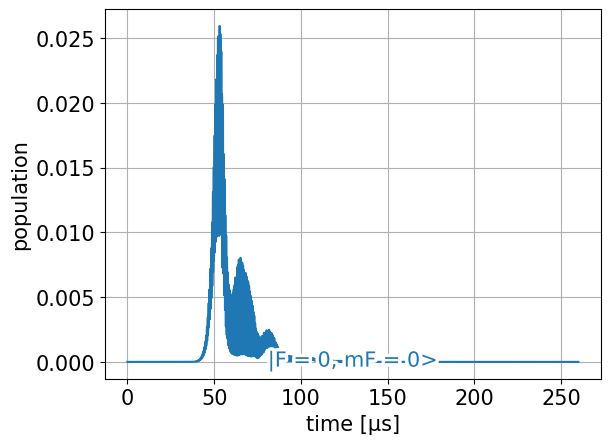

In [17]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"])
    for idx in indices_excited
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")

# photons = 2.0


rate = 7.68e+03 /s


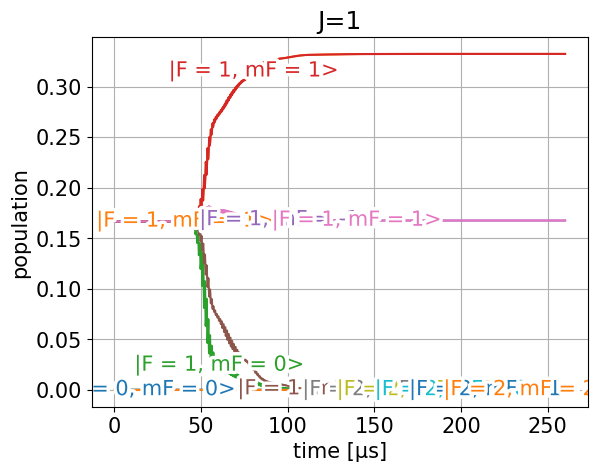

In [18]:
for J, ind in enumerate(
    [indices_J0, indices_J1, indices_J2, indices_J3, indices_J4, indices_J5]
):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} /s")

# Trajectories

In [19]:
def generate_random_longitudinal_velocities(n, vμ, vσ):
    """generate random longitudinal velocities

    Args:
        n (int): number of velocities to genrate
        vμ (float): mean velocity
        vσ (float): σ velocity width

    Returns:
        np.ndarray: 1D array with longitudinal velocities
    """
    return np.random.normal(vμ, vσ, n)


def generate_random_transverse_velocities(n, vσ):
    """generate random transverse velocities

    Args:
        n (int): number of velocities to generate
        vσ (float): σ width of transverse velocity distribution

    Returns:
        np.ndarray: 2D array with transverse velocities
    """
    velocities = np.random.multivariate_normal(
        [0, 0], np.array([[vσ**2, 0], [0, vσ**2]]), n
    ).T
    return velocities


def generate_random_coords_circle_2D(n, σ):
    """generate random xy coordinates in a circle

    Args:
        n (int): number of coordinates to generate
        σ (float): σ width of circle to generate coordinates in

    Returns:
        np.ndarray: 2D array with xy coordinates
    """

    def generate_random_r(n, σ):
        return np.random.normal(0, σ, n)

    xy = np.empty([2, n])
    xy[0, :] = generate_random_r(n, σ)
    xy[1, :] = generate_random_r(n, σ)
    return xy

In [20]:
save_idxs_excited = [
    v.item()
    for v in utils.population.get_diagonal_indices_flattened(
        size=len(obe_system.QN), states=indices_excited, mode="julia"
    )
]


In [21]:
output_function = lindblad_julia.setup_state_integral_calculation_state_idxs(
    nphotons=True, Γ=hamiltonian.Γ
)

callback_function = lindblad_julia.setup_discrete_callback_terminate(
    odepars, "vz*t >= 50e-3"
)

In [22]:
n = int(1e7)
vz = generate_random_longitudinal_velocities(n, vcm, vcm_sigma)
vx, vy = generate_random_transverse_velocities(n, vperp_sigma)
x0, y0 = generate_random_coords_circle_2D(n, 0.0025)
apertures = [(47e-3, 6.35e-3), (73e-3, 12.7e-3), (290e-3, 2.54e-3)]
mask = np.ones(n, dtype=bool)
for location, diameter in apertures:
    t = location / vz
    r = np.sqrt((x0 + vx * t) ** 2 + (y0 + vy * t) ** 2)
    m = r < diameter / 2
    mask &= m

In [23]:
start_loc = 358e-3 - 0.03556 / 2 - 10e-3
t = start_loc / vz
x0, y0 = x0 + vx * t, y0 + vy * t

δl_vx = utils.detuning.velocity_to_detuning(vx[mask])

In [24]:
δls = (
    np.append(np.append(-np.logspace(*δ_range), [0]), np.logspace(*δ_range)[::-1])
    * hamiltonian.Γ
)
vzs = np.linspace(*vz_range)
y0s = np.linspace(*y0_range)

parameters = ["vz", "δ0", "y0"]
parameter_values = [
    vzs,
    δls,
    y0s,
]

In [25]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 1000e-6))

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    distributed_method="EnsembleDistributed()",
    save_everystep=True,
    save_idxs=save_idxs_excited,
    callback=callback_function,
    reltol=1e-4,
    abstol=1e-7,
    saveat=1e-7,
)

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=parameter_values,
    output_func=output_function,
    zipped=False,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

In [26]:
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [27]:
results_scan = lindblad_julia.get_results_parameter_scan(ensemble_problem)

In [28]:
interpolator = interpolate.RegularGridInterpolator(
    points=ensemble_problem.scan_values,
    values=results_scan.results,
    method="linear",
    bounds_error=False,
    fill_value=np.nan,
)

In [29]:
photons = []
for δ in np.linspace(-50, 50, 101) * 2 * np.pi * 1e6:
    res = interpolator(np.array([vz[mask], δl_vx + δ, y0[mask]]).T)
    photons.append(np.nanmean(res))

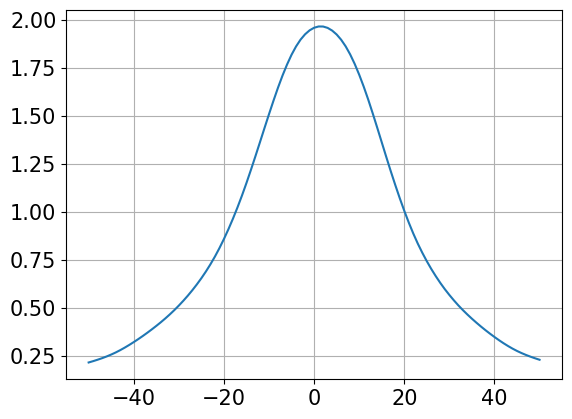

In [30]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-50, 50, 101), photons)
ax.grid()

In [31]:
np.savez(
    fname.with_name(fname.stem + " results"),
    results=results_scan.results,
    vz=vzs,
    δ=δls,
    y0=y0s,
    indices_coupled=indices_coupled,
)